In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((256, 256)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='t', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [2]:
from torch import nn
import torch
import torch as th

import torch.nn.functional as F


def conv(in_channels, out_channels, use_bias=False):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=use_bias),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1),
    )

class Classifier(nn.Module):
    def __init__(self, dims=[400,400], out_channels=2, use_bias=False, freeze_bn=False):
        super().__init__()
        #TODO: vary architecture
        
        self.conv1 = conv(3, 16)
        self.conv2 = conv(16,32)
        self.conv3 = conv(32,64)

        self.fc1 = nn.Linear(64 * int(dims[0]/8) * int
        (dims[1]/8), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_channels)

        self._initialize_weights()

        if freeze_bn:
            self.freeze_bn()
            
        # placeholder for the gradients
        self.gradients = None

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        h = x.register_hook(self.activations_hook)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

    def freeze_bn(self):
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        ret = self.conv1(x)
        ret = self.conv2(ret)
        ret = self.conv3(ret)
        return ret


In [3]:
net = Classifier(out_channels=6, dims=[256, 256], use_bias=False)
checkpoint_file="simple_coffee.ckpt"
checkpoint = th.load(checkpoint_file, map_location="cpu")
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
net.eval()

Classifier(
  (conv1): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=65536, out_featur

In [5]:
# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = net(img)

pred_i = pred.argmax(dim=1)

pred, pred_i

TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>

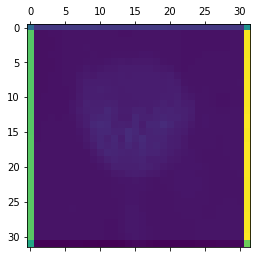

In [31]:
# get the gradient of the output with respect to the parameters of the model
# pred[:, 386].backward()
pred[:,pred_i].backward()

# pull the gradients out of the model
gradients = net.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = net.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(64):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [28]:
gradients.shape

torch.Size([1, 64, 32, 32])

In [33]:
heatmap2 = heatmap.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


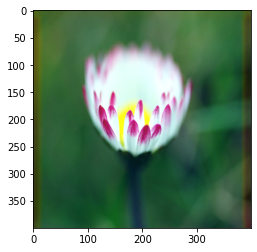

In [34]:
import cv2
img = cv2.imread('./t/flowers/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap2 = cv2.resize(heatmap2, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
heatmap2 = cv2.cvtColor(heatmap2, cv2.COLOR_BGR2RGB)
superimposed_img = heatmap2 * 0.1 + img * 1.0
superimposed_img = superimposed_img.astype(int)
    # cv2.imwrite('./map.jpg', superimposed_img)
plt.imshow(superimposed_img)

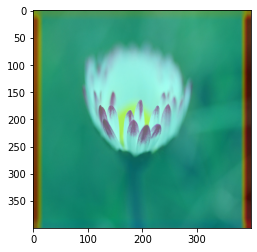

In [35]:
superimposed_img = heatmap2 * 0.4 + img * .6
superimposed_img = superimposed_img.astype(int)
plt.imshow(superimposed_img)